In [50]:
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance
import os
import io

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm

import tensorflow as tf
import keras

import re
from typing import Tuple, List, Dict

In [51]:
# Load our wiki art csv
verified_df = pd.read_csv("verified_artwork_data.csv")

In [52]:
verified_df.head()

,id,title,url,artistUrl,artistName,artistId,completitionYear,width,image,height,movement,file_path
0,57728a68edc2cb388010fa7e,Adelina Morton,NaN,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1810.0,496,https://uploads5.wikiart.org/images/joshua-joh...,600,naive_art,downloaded_images_wikiart\naive_art\57728a68ed...
1,57728a68edc2cb388010fa90,BENJAMIN FRANKLIN YOE AND SON,NaN,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1810.0,483,https://uploads2.wikiart.org/images/joshua-joh...,600,naive_art,downloaded_images_wikiart\naive_art\57728a68ed...
2,57728a69edc2cb388010faa0,Edward and Sarah Rutter,NaN,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1805.0,450,https://uploads4.wikiart.org/images/joshua-joh...,507,naive_art,downloaded_images_wikiart\naive_art\57728a69ed...
3,57728a69edc2cb388010fab0,Family Group,NaN,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1800.0,750,https://uploads3.wikiart.org/images/joshua-joh...,483,naive_art,downloaded_images_wikiart\naive_art\57728a69ed...
4,57728a69edc2cb388010fac0,Girl Wearing a Bonnet,NaN,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1810.0,504,https://uploads3.wikiart.org/images/joshua-joh...,600,naive_art,downloaded_images_wikiart\naive_art\57728a69ed...


In [53]:
# Fix column name typo
verified_df.rename(columns={'completitionYear' : 'completionYear'},inplace=True)

In [54]:
verified_df['movement'].value_counts()

movement
early_renaissance         466
abstract_expressionism    459
post_impressionism        458
minimalism                453
impressionism             444
expressionism             440
surrealism                434
high_renaissance          433
northern_renaissance      426
cubism                    413
pop_art                   392
fauvism                   361
baroque                   351
romanticism               336
mannerism                 327
art_informel              319
modernism                 301
rococo                    287
contemporary              280
american_realism          272
neoclassicism             272
art_nouveau               256
naive_art                 243
symbolism                 234
ukiyo_e                   230
art_deco                  147
neo_romantic               80
Name: count, dtype: int64

### Curating the image set 

In [55]:
verified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9114 entries, 0 to 9113
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9114 non-null   object 
 1   title           9114 non-null   object 
 2   url             0 non-null      float64
 3   artistUrl       9114 non-null   object 
 4   artistName      9114 non-null   object 
 5   artistId        9114 non-null   object 
 6   completionYear  7798 non-null   float64
 7   width           9114 non-null   int64  
 8   image           9114 non-null   object 
 9   height          9114 non-null   int64  
 10  movement        9114 non-null   object 
 11  file_path       9114 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 854.6+ KB


In [56]:
artist_list = verified_df['artistName'].unique()
print("artist order:")
for i, style in enumerate(artist_list):
    print(f"{i}: {style}")

artist order:
0: Joshua Johnson
1: Henri Rousseau
2: Edward Hicks
3: John Bradley
4: Alfred Wallis
5: Grandma Moses
6: Louis Vivin
7: Seraphine Louis
8: Paul Bril
9: Agostino Carracci
10: Annibale Carracci
11: Hendrick Cornelisz Vroom
12: Francesco Ribalta
13: Caravaggio
14: Jan Brueghel the Elder
15: Peter Paul Rubens
16: Georges Lallemand
17: Guido Reni
18: Francisco Herrera
19: Francois Boucher
20: Jean-Honore Fragonard
21: Antoine Watteau
22: Jean-Marc Nattier
23: Maurice Quentin de La Tour
24: Jean-Baptiste van Loo
25: Giovanni Battista Tiepolo
26: Rosalba Carriera
27: Caspar David Friedrich
28: J.M.W. Turner
29: Eugene Delacroix
30: John Constable
31: Thomas Cole
32: William Blake
33: Henry Fuseli
34: Francisco Goya
35: Philipp Otto Runge
36: Tamara de Lempicka
37: Erte
38: Cassandre
39: Jean Dupas
40: Edward Hopper
41: Andrew Wyeth
42: Charles Sheeler
43: George Bellows
44: Thomas Hart Benton
45: Edwin Dickinson
46: Ben Shahn
47: Ivan Albright
48: Alphonse Mucha
49: Gustav Klimt

In [57]:
cont_list = verified_df[verified_df['movement'] == 'contemporary']
cont_list['artistName'].value_counts()

artistName
Peter Doig                 40
Luc Tuymans                40
Njideka Akunyili Crosby    40
Anselm Kiefer              39
Jenny Saville              36
Adrian Ghenie              23
Kerry James Marshall       22
Neo Rauch                  18
Julie Mehretu              15
Marlene Dumas               7
Name: count, dtype: int64

In [58]:
def create_contemporary_mappings():
    """Define style mappings for contemporary artists based on work characteristics"""
    
    contemporary_style_keywords = {
        'Peter Doig': {
            'neo_romantic': ['landscape', 'cabin', 'canoe', 'forest', 'night'],
            'symbolism': ['ghost', 'reflection', 'echo', 'pelican', 'lion']
        },
        'Anselm Kiefer': {
            'expressionism': ['ash', 'lead', 'straw', 'burning', 'field'],
            'symbolism': ['merkaba', 'lilith', 'cathedral', 'throne', 'wing']
        },
        'Jenny Saville': {
            'expressionism': ['flesh', 'body', 'torso', 'hybrid', 'nude'],
            'american_realism': ['portrait', 'study', 'figure']
        },
        'Neo Rauch': {
            'surrealism': ['dream', 'waiting', 'garden', 'factory', 'ritual'],
            'american_realism': ['worker', 'village', 'house']
        },
        'Marlene Dumas': {
            'expressionism': ['face', 'portrait', 'figure', 'skull', 'death']
        },
        'Adrian Ghenie': {
            'expressionism': ['degenerate', 'boogeyman', 'flesh', 'study'],
            'surrealism': ['pie fight', 'darwin', 'meditation']
        },
        'Kerry James Marshall': {
            'american_realism': ['portrait', 'beauty', 'garden', 'studio', 'painter']
        },
        'Julie Mehretu': {
            'abstract_expressionism': ['emergence', 'conjured', 'stadia'],
            'modernism': ['algorithm', 'retopistics', 'systematic']
        }
    }
    
    # Default styles for when keywords don't match
    contemporary_default_styles = {
        'Peter Doig': 'neo_romantic',
        'Anselm Kiefer': 'expressionism',
        'Jenny Saville': 'expressionism',
        'Neo Rauch': 'surrealism',
        'Marlene Dumas': 'expressionism',
        'Adrian Ghenie': 'expressionism',
        'Kerry James Marshall': 'american_realism',
        'Julie Mehretu': 'abstract_expressionism'
    }
    
    return contemporary_style_keywords, contemporary_default_styles

def reclassify_contemporary(df):
    """
    Reclassify contemporary works based on title keywords and artist defaults
    """
    keywords, defaults = create_contemporary_mappings()
    df = df.copy()
    
    for artist, style_keywords in keywords.items():
        artist_mask = df['artistName'] == artist
        if not artist_mask.any():
            continue
            
        # Start with default style
        df.loc[artist_mask, 'movement'] = defaults[artist]
        
        # Check title keywords for specific styles
        for style, words in style_keywords.items():
            for keyword in words:
                title_mask = df['title'].str.lower().str.contains(keyword.lower(), na=False)
                df.loc[artist_mask & title_mask, 'movement'] = style
    
    return df

def validate_contemporary_reclassification(df):
    """
    Validate the reclassification of contemporary works
    """
    keywords, defaults = create_contemporary_mappings()
    
    report = []
    for artist in keywords.keys():
        artist_works = df[df['artistName'] == artist]
        if len(artist_works) == 0:
            continue
            
        movements = artist_works['movement'].value_counts()
        report.append({
            'artist': artist,
            'total_works': len(artist_works),
            'movement_distribution': movements.to_dict()
        })
    
    return report

In [59]:

def create_artist_style_mappings():
    """Define time periods and special cases for multi-style artists"""
    artist_periods = {
        'Pablo Picasso': {
            'post_impressionism': (None, 1901),
            'cubism': (1907, 1925),
            'surrealism': (1925, 1935)
        },
        'Wassily Kandinsky': {
            'art_nouveau': (None, 1908),
            'expressionism': (1908, 1914),
            'modernism': (1914, None)
        },
        'Henri Matisse': {
            'post_impressionism': (None, 1905),
            'fauvism': (1905, 1917),
            'modernism': (1917, None)
        },
        'Willem de Kooning': {
            'american_realism': (None, 1945),
            'abstract_expressionism': (1945, None)
        },
        'Philip Guston': {
            'abstract_expressionism': (1950, 1967),
            'american_realism': (1968, None)
        },
        'Joan Miro': {
            'post_impressionism': (None, 1917),
            'surrealism': (1917, 1955),
            'modernism': (1955, None)
        },
        'Vincent van Gogh': {
            'post_impressionism': (1886, None),  # Earlier work not in your style list
        },
        'Paul Gauguin': {
            'impressionism': (None, 1886),
            'post_impressionism': (1886, None)
        },
        'Georges Braque': {
            'post_impressionism': (None, 1907),
            'cubism': (1907, None)
        },
        'Piet Mondrian': {
            'post_impressionism': (None, 1911),
            'modernism': (1911, 1917),
            'minimalism': (1917, None)
        },
        "Georgia O'Keeffe": {
            'american_realism': (None, 1918),
            'modernism': (1918, None)
        },
        'Giorgio de Chirico': {
            'symbolism': (None, 1910),
            'surrealism': (1910, None)
        },
        'Marc Chagall': {
            'post_impressionism': (None, 1910),
            'modernism': (1910, None)
        },
        'Paul Klee': {
            'expressionism': (1911, 1920),
            'surrealism': (1920, 1935),
            'modernism': (1935, None)
        },
        'Fernand Leger': {
            'post_impressionism': (None, 1907),
            'cubism': (1907, 1920),
            'modernism': (1920, None)
        },
        'Max Ernst': {
            'expressionism': (None, 1919),
            'surrealism': (1919, None)
        }
    }
    
    # Special cases based on title keywords
    title_keywords = {
        'Pablo Picasso': {
            'guernica': 'surrealism',
            'demoiselles': 'cubism',
            'blue': 'post_impressionism',
            'rose': 'post_impressionism'
        },
        'Giorgio de Chirico': {
            'mystery': 'surrealism',
            'metaphysical': 'surrealism',
            'enigma': 'surrealism',
            'melancholy': 'symbolism'
        },
        'Philip Guston': {
            'abstract': 'abstract_expressionism',
            'hood': 'american_realism'  # His later figurative works often featured hood motifs
        },
        'Piet Mondrian': {
            'composition': 'minimalism',
            'tree': 'post_impressionism',
            'broadway': 'minimalism'
        },
        "Georgia O'Keeffe": {
            'flower': 'modernism',
            'skull': 'modernism',
            'city': 'modernism'
        }
    }
    
    return artist_periods, title_keywords

def filter_multi_style_artists(df):
    """
    Filter and correct movement labels for multi-style artists based on completion year
    and title keywords.
    """
    artist_periods, title_keywords = create_artist_style_mappings()
    df = df.copy()
    
    for artist, periods in artist_periods.items():
        artist_mask = df['artistName'] == artist
        if not artist_mask.any():
            continue
            
        for style, (start_year, end_year) in periods.items():
            year_mask = True
            if start_year is not None:
                year_mask = year_mask & (df['completionYear'] >= start_year)
            if end_year is not None:
                year_mask = year_mask & (df['completionYear'] < end_year)
                
            # Update movement where artist and year conditions match
            df.loc[artist_mask & year_mask, 'movement'] = style
    
    # Handle special cases based on title keywords
    for artist, keywords in title_keywords.items():
        artist_mask = df['artistName'] == artist
        if not artist_mask.any():
            continue
            
        for keyword, style in keywords.items():
            # Case-insensitive keyword search in title
            title_mask = df['title'].str.lower().str.contains(keyword.lower(), na=False)
            df.loc[artist_mask & title_mask, 'movement'] = style
    
    return df

def validate_artist_styles(df):
    """
    Validate and report on the movement assignments for multi-style artists.
    """
    artist_periods = create_artist_style_mappings()[0]
    
    report = []
    for artist in artist_periods.keys():
        artist_works = df[df['artistName'] == artist]
        if len(artist_works) == 0:
            continue
            
        movements = artist_works['movement'].value_counts()
        report.append({
            'artist': artist,
            'total_works': len(artist_works),
            'movement_distribution': movements.to_dict(),
            'missing_movement': artist_works['movement'].isna().sum()
        })
    
    return report

In [60]:
artist_periods, title_keywords = create_artist_style_mappings()
curated_df = filter_multi_style_artists(verified_df)
curated_df = reclassify_contemporary(curated_df)

curated_df['movement'].value_counts()

movement
expressionism             534
post_impressionism        485
minimalism                467
early_renaissance         466
impressionism             455
surrealism                446
high_renaissance          433
northern_renaissance      426
cubism                    413
abstract_expressionism    401
pop_art                   392
modernism                 358
baroque                   351
romanticism               336
american_realism          329
mannerism                 327
art_informel              319
fauvism                   293
rococo                    287
neoclassicism             272
art_nouveau               266
naive_art                 243
symbolism                 239
ukiyo_e                   230
art_deco                  147
neo_romantic              119
contemporary               80
Name: count, dtype: int64

In [61]:
curated_df = curated_df[curated_df['movement'] != 'contemporary'].reset_index(drop=True)

In [62]:

class ArtworkFilter:
    def __init__(self, df: pd.DataFrame):
        """
        Initialize the filter with a DataFrame containing artwork data.
        
        Args:
            df: DataFrame with columns including 'title', 'movement', 'file_path', etc.
        """
        self.df = df.copy()
        self.filtered_df = None
        
        # Keywords that might indicate sketches/studies
        self.sketch_keywords = {
            'sketch', 'study', 'drawing', 'preparatory', 'preliminary', 
            'draft', 'cartoon', 'studies', 'sketches', 'drawings',
            'detail', 'fragment', 'preparation', 'practice'
        }
        
        # Mapping of movements to their typical mediums
        self.movement_mediums = {
            'early_renaissance': {'fresco', 'tempera', 'oil'},
            'high_renaissance': {'oil', 'fresco'},
            'northern_renaissance': {'oil', 'panel'},
            'baroque': {'oil'},
            'rococo': {'oil'},
            # Add more movements as needed
        }

    def detect_sketches_by_title(self) -> pd.Series:
        """
        Detect potential sketches based on title keywords.
        Returns a boolean Series where True indicates a likely sketch.
        """
        title_lower = self.df['title'].str.lower()
        return title_lower.apply(lambda x: any(keyword in str(x) for keyword in self.sketch_keywords))

    def analyze_image_properties(self, file_path: str) -> Dict:
        """
        Analyze image properties to detect potential sketches/low quality images.
        
        Args:
            file_path: Path to the image file
            
        Returns:
            Dict containing image properties
        """
        try:
            with Image.open(file_path) as img:
                # Convert to grayscale for analysis
                gray_img = img.convert('L')
                img_array = np.array(gray_img)
                
                # Calculate various image properties
                properties = {
                    'std_dev': np.std(img_array),  # Low variance might indicate sketches
                    'mean_value': np.mean(img_array),  # Very high mean might indicate overexposed
                    'contrast_ratio': (np.percentile(img_array, 95) - np.percentile(img_array, 5)) / 255,
                    'resolution_score': img.size[0] * img.size[1] / (1000 * 1000)  # Normalized resolution
                }
                return properties
        except Exception as e:
            return None

    def filter_artwork(self, 
                      min_resolution: float = 0.1,  # Minimum resolution in megapixels
                      min_contrast: float = 0.2,    # Minimum contrast ratio
                      confidence_threshold: float = 0.7) -> pd.DataFrame:
        """
        Apply multiple filtering criteria to remove potentially problematic images.
        
        Args:
            min_resolution: Minimum acceptable resolution in megapixels
            min_contrast: Minimum acceptable contrast ratio
            confidence_threshold: Threshold for confidence in keeping an image
            
        Returns:
            Filtered DataFrame
        """
        # Initialize quality scores
        quality_scores = pd.Series(1.0, index=self.df.index)
        
        # 1. Title-based filtering
        sketch_indicators = self.detect_sketches_by_title()
        quality_scores[sketch_indicators] *= 0.5
        
        # 2. Image property analysis
        for idx, row in self.df.iterrows():
            props = self.analyze_image_properties(row['file_path'])
            if props:
                # Penalize low resolution
                if props['resolution_score'] < min_resolution:
                    quality_scores[idx] *= 0.7
                
                # Penalize low contrast (might indicate sketches)
                if props['contrast_ratio'] < min_contrast:
                    quality_scores[idx] *= 0.8
        
        # 3. Movement-specific rules
        for movement, mediums in self.movement_mediums.items():
            movement_mask = self.df['movement'] == movement
            if movement_mask.any():
                # Apply stricter filtering for movements where sketches are less common
                title_lower = self.df[movement_mask]['title'].str.lower()
                medium_match = title_lower.apply(
                    lambda x: any(medium in str(x) for medium in mediums)
                )
                quality_scores[movement_mask & ~medium_match] *= 0.9
        
        # Filter based on final quality scores
        self.filtered_df = self.df[quality_scores >= confidence_threshold].copy()
        
        # Add quality score for reference
        self.filtered_df['quality_score'] = quality_scores[quality_scores >= confidence_threshold]
        
        return self.filtered_df

    def get_filtering_stats(self) -> Dict:
        """
        Return statistics about the filtering process.
        """
        if self.filtered_df is None:
            raise ValueError("Must run filter_artwork() first")
            
        stats = {
            'original_count': len(self.df),
            'filtered_count': len(self.filtered_df),
            'removed_count': len(self.df) - len(self.filtered_df),
            'removal_percentage': (1 - len(self.filtered_df) / len(self.df)) * 100,
            'movement_stats': {
                movement: {
                    'before': len(self.df[self.df['movement'] == movement]),
                    'after': len(self.filtered_df[self.filtered_df['movement'] == movement])
                }
                for movement in self.df['movement'].unique()
            }
        }
        return stats

In [63]:
# Initialize the filter
artwork_filter = ArtworkFilter(curated_df)

# Apply the filtering
filtered_df = artwork_filter.filter_artwork(
    min_resolution=0.1,  # Minimum 0.1 megapixels
    min_contrast=0.2,    # Minimum contrast ratio
    confidence_threshold=0.7  # Keep images with quality score >= 0.7
)

# Get statistics about the filtering
stats = artwork_filter.get_filtering_stats()

In [64]:
stats

{'original_count': 9034,
 'filtered_count': 8774,
 'removed_count': 260,
 'removal_percentage': 2.8780163825547933,
 'movement_stats': {'naive_art': {'before': 243, 'after': 243},
  'baroque': {'before': 351, 'after': 345},
  'rococo': {'before': 287, 'after': 278},
  'romanticism': {'before': 336, 'after': 329},
  'art_deco': {'before': 147, 'after': 144},
  'american_realism': {'before': 329, 'after': 325},
  'art_nouveau': {'before': 266, 'after': 253},
  'expressionism': {'before': 534, 'after': 527},
  'modernism': {'before': 358, 'after': 356},
  'post_impressionism': {'before': 485, 'after': 480},
  'impressionism': {'before': 455, 'after': 447},
  'high_renaissance': {'before': 433, 'after': 410},
  'cubism': {'before': 413, 'after': 411},
  'surrealism': {'before': 446, 'after': 442},
  'abstract_expressionism': {'before': 401, 'after': 396},
  'art_informel': {'before': 319, 'after': 318},
  'mannerism': {'before': 327, 'after': 320},
  'northern_renaissance': {'before': 426,

### Image Preprocessing
- Resizing to standard sizes
- Convert floating point arrays
- Normalize 
- Augment the images to address class imbalance

In [65]:
def check_image_sizes(df):
    """
    Checks all unique image sizes in the dataset using existing file_paths
    
    Args:
        df: DataFrame containing 'file_path' column
        
    Returns:
        set: Set of unique (width, height) tuples found in the dataset
    """
    image_sizes = set()
    
    print("Checking image sizes...")
    for _, row in tqdm(df.iterrows()):
        try:
            with Image.open(row['file_path']) as img:
                image_sizes.add(img.size)
        except Exception as e:
            print(f"Error processing {row['file_path']}: {str(e)}")
    

    
    return image_sizes

# Run the check
size_list = check_image_sizes(filtered_df)
print("\nTotal unique sizes:", len(size_list))

Checking image sizes...


8774it [00:02, 3923.54it/s]


Total unique sizes: 2491


In [66]:
def letterbox_resize(image, target_size):
    """
    Resize an image to a square target size while maintaining aspect ratio using letterboxing.
    Uses the mean color of the image for padding instead of black.
    
    Args:
        image: PIL Image object
        target_size: int, desired width and height of the square output
    
    Returns:
        PIL Image object with dimensions (target_size, target_size)
    """
    # Get original dimensions
    w, h = image.size
    ratio = min(target_size / w, target_size / h)
    
    # Calculate new dimensions
    new_w = int(w * ratio)
    new_h = int(h * ratio)
    
    # Resize the image
    resized = image.resize((new_w, new_h), Image.LANCZOS)
    
    # Calculate mean color of the image
    img_array = np.array(image)
    mean_color = tuple(map(int, np.mean(img_array, axis=(0, 1))))
    
    # Create a new image with mean color background
    new_image = Image.new('RGB', (target_size, target_size), mean_color)
    
    # Calculate padding
    x_offset = (target_size - new_w) // 2
    y_offset = (target_size - new_h) // 2
    
    # Paste the resized image into the center
    new_image.paste(resized, (x_offset, y_offset))
    
    return new_image


In [67]:
def process_images(df, target_size=256, output_dir='resized_imgs_curated'):
    """
    Process all images in the DataFrame, resize them, and save to output directory.
    
    Args:
        df: DataFrame containing 'file_path' column
        target_size: Size for the square output images (default: 256)
        output_dir: Directory to save resized images (default: 'resized_imgs_curated')
    
    Returns:
        DataFrame with updated file_paths
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    # Keep track of any failures
    failed_processes = []
    
    print(f"Processing {len(df)} images...")
    
    # Process each image with progress bar
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            # Load the image
            with Image.open(row['file_path']) as img:
                # Resize image
                resized_img = letterbox_resize(img, target_size)
                
                # Get original filename from path and create new path
                filename = os.path.basename(row['file_path'])
                new_path = os.path.join(output_dir, filename)
                
                # Save the resized image
                resized_img.save(new_path, quality=95)  
                
                # Update DataFrame with new path
                df.loc[idx, 'file_path'] = new_path
                
        except Exception as e:
            failed_processes.append({
                'original_path': row['file_path'],
                'error': str(e)
            })
            print(f"\nError processing {row['file_path']}: {e}")
    
    # Print summary
    print("\nProcessing Summary:")
    print(f"Total images processed: {len(df) - len(failed_processes)}")
    print(f"Failed processes: {len(failed_processes)}")
    
    if failed_processes:
        print("\nFailed processes details:")
        for fail in failed_processes:
            print(f"Path: {fail['original_path']}")
            print(f"Error: {fail['error']}")
            print("-" * 50)
    
    # Verify all images in the output directory are the correct size
    print("\nVerifying output images...")
    incorrect_sizes = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        if os.path.exists(row['file_path']):
            with Image.open(row['file_path']) as img:
                if img.size != (target_size, target_size):
                    incorrect_sizes.append(row['file_path'])
    
    if incorrect_sizes:
        print(f"\nWarning: Found {len(incorrect_sizes)} images with incorrect size")
        
    return df

# Process all images
processed_df = process_images(filtered_df, target_size=256)

Processing 8774 images...


  4%|▍         | 341/8774 [00:03<01:25, 98.17it/s] 


Error processing downloaded_images_wikiart\baroque\57727652edc2cb3880d1399e.jpg: 'numpy.float64' object is not iterable


 13%|█▎        | 1147/8774 [00:12<01:15, 100.63it/s]


Error processing downloaded_images_wikiart\romanticism\57726f46edc2cb3880b9fdfd.jpg: 'numpy.float64' object is not iterable

Error processing downloaded_images_wikiart\romanticism\57726f46edc2cb3880b9fe3f.jpg: 'numpy.float64' object is not iterable

Error processing downloaded_images_wikiart\romanticism\57726f46edc2cb3880b9fe8f.jpg: 'numpy.float64' object is not iterable


 22%|██▏       | 1902/8774 [00:19<01:07, 101.31it/s]


Error processing downloaded_images_wikiart\expressionism\57726e20edc2cb3880b60269.jpg: 'numpy.float64' object is not iterable


 54%|█████▍    | 4764/8774 [00:47<00:43, 92.54it/s] 


Error processing downloaded_images_wikiart\northern_renaissance\57726e40edc2cb3880b6916f.jpg: 'numpy.float64' object is not iterable


 55%|█████▍    | 4817/8774 [00:48<00:40, 98.19it/s]


Error processing downloaded_images_wikiart\northern_renaissance\577275a0edc2cb3880cec572.jpg: 'numpy.float64' object is not iterable


 56%|█████▌    | 4888/8774 [00:48<00:35, 109.70it/s]


Error processing downloaded_images_wikiart\northern_renaissance\57726e4eedc2cb3880b6a5cb.jpg: 'numpy.float64' object is not iterable


 67%|██████▋   | 5890/8774 [00:58<00:29, 98.35it/s] 


Error processing downloaded_images_wikiart\early_renaissance\57727019edc2cb3880bcf17f.jpg: 'numpy.float64' object is not iterable


100%|██████████| 8774/8774 [01:27<00:00, 100.46it/s]



Processing Summary:
Total images processed: 8765
Failed processes: 9

Failed processes details:
Path: downloaded_images_wikiart\baroque\57727652edc2cb3880d1399e.jpg
Error: 'numpy.float64' object is not iterable
--------------------------------------------------
Path: downloaded_images_wikiart\romanticism\57726f46edc2cb3880b9fdfd.jpg
Error: 'numpy.float64' object is not iterable
--------------------------------------------------
Path: downloaded_images_wikiart\romanticism\57726f46edc2cb3880b9fe3f.jpg
Error: 'numpy.float64' object is not iterable
--------------------------------------------------
Path: downloaded_images_wikiart\romanticism\57726f46edc2cb3880b9fe8f.jpg
Error: 'numpy.float64' object is not iterable
--------------------------------------------------
Path: downloaded_images_wikiart\expressionism\57726e20edc2cb3880b60269.jpg
Error: 'numpy.float64' object is not iterable
--------------------------------------------------
Path: downloaded_images_wikiart\northern_renaissance\57

100%|██████████| 8774/8774 [01:32<00:00, 94.96it/s] 

In [68]:
# Check sizes after processing
size_list = check_image_sizes(processed_df) 
print("\nTotal unique sizes:", len(size_list))

Checking image sizes...


8774it [00:09, 948.90it/s] 


Total unique sizes: 10


In [69]:
# Checking new file path
processed_df['file_path'].head()

0    resized_imgs_curated\57728a68edc2cb388010fa7e.jpg
1    resized_imgs_curated\57728a68edc2cb388010fa90.jpg
2    resized_imgs_curated\57728a69edc2cb388010faa0.jpg
3    resized_imgs_curated\57728a69edc2cb388010fab0.jpg
4    resized_imgs_curated\57728a69edc2cb388010fac0.jpg
Name: file_path, dtype: object

In [70]:
# Convert to floating point and normalize
def load_and_normalize_image(file_path):
    """
    Load image from file_path, convert to float32 array and normalize to [0, 1] range
    
    Args:
        file_path (str): Path to the image file
        
    Returns:
        numpy.ndarray: Normalized image array of shape (height, width, 3) in float32
    """
    # Load image
    img = Image.open(file_path)
    
    # Convert to RGB if not already
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert to numpy array and change type to float32
    img_array = np.array(img, dtype=np.float32)
    
    # Normalize to [0, 1] range
    img_array = img_array / 255.0
    
    return img_array

# Apply to the DataFrame to create a new column with normalized arrays
processed_df['image_array'] = processed_df['file_path'].apply(load_and_normalize_image)

In [72]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8774 entries, 0 to 9033
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8774 non-null   object 
 1   title           8774 non-null   object 
 2   url             0 non-null      float64
 3   artistUrl       8774 non-null   object 
 4   artistName      8774 non-null   object 
 5   artistId        8774 non-null   object 
 6   completionYear  7506 non-null   float64
 7   width           8774 non-null   int64  
 8   image           8774 non-null   object 
 9   height          8774 non-null   int64  
 10  movement        8774 non-null   object 
 11  file_path       8774 non-null   object 
 12  quality_score   8774 non-null   float64
 13  image_array     8774 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 1.3+ MB


In [73]:
# Get class distribution
class_counts = processed_df['movement'].value_counts()
target_count = 600

def augment_and_save_image(img_array, original_path, num_augmentations):
    """
    Create and save augmented versions of an image using TensorFlow and PIL
    while preserving key movement characteristics
    """
    new_paths = []
    base_name = os.path.splitext(os.path.basename(original_path))[0]
    ext = os.path.splitext(original_path)[1]
    
    if num_augmentations <= 0:
        return new_paths
        
    # Convert numpy array to PIL Image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    print(f"\nProcessing image: {base_name}")
    print(f"Initial image mean pixel value: {np.mean(img_array):.3f}")
    
    # Define augmentation ranges - keeping conservative to preserve movement
    brightness_range = (0.9, 1.1)
    contrast_range = (0.9, 1.1)
    saturation_range = (0.95, 1.05)
    hue_range = (-0.05, 0.05)
    
    for i in range(num_augmentations):
        print(f"\nAugmentation {i+1}:")
        
        # Convert PIL image to TensorFlow tensor
        tf_img = tf.convert_to_tensor(np.array(img))
        tf_img = tf.cast(tf_img, tf.float32) / 255.0
        tf_img = tf.expand_dims(tf_img, 0)  # Add batch dimension
        
        # Random horizontal flip
        if np.random.random() < 0.5:
            tf_img = tf.image.flip_left_right(tf_img)
            print("Applied horizontal flip")
        
        # Apply color transformations using TensorFlow
        # Random brightness
        tf_img = tf.image.random_brightness(
            tf_img, 
            max_delta=(brightness_range[1] - 1.0)
        )
        
        # Random contrast
        tf_img = tf.image.random_contrast(
            tf_img,
            lower=contrast_range[0],
            upper=contrast_range[1]
        )
        
        # Random saturation
        tf_img = tf.image.random_saturation(
            tf_img,
            lower=saturation_range[0],
            upper=saturation_range[1]
        )
        
        # Random hue
        tf_img = tf.image.random_hue(
            tf_img,
            max_delta=hue_range[1]
        )
        
        # Ensure values are in valid range
        tf_img = tf.clip_by_value(tf_img, 0.0, 1.0)
        
        # Convert back to numpy and remove batch dimension
        aug_array = tf_img[0].numpy()
        
        # Random rotation using PIL
        aug_img = Image.fromarray((aug_array * 255).astype(np.uint8))
        rotation = np.random.uniform(-10, 10)
        aug_img = aug_img.rotate(rotation, resample=Image.BICUBIC, fillcolor=0)
        print(f"Applied rotation: {rotation:.1f} degrees")
        
        # Convert to numpy for cropping
        aug_array = np.array(aug_img)
        print(f"After color transforms: mean={np.mean(aug_array):.3f}, min={np.min(aug_array)}, max={np.max(aug_array)}")
        
        # Random crop (80% of original size)
        h, w = aug_array.shape[:2]
        crop_size = int(min(h, w) * 0.8)
        start_h = np.random.randint(0, h - crop_size + 1)
        start_w = np.random.randint(0, w - crop_size + 1)
        aug_array = aug_array[start_h:start_h+crop_size, start_w:start_w+crop_size]
        print(f"After cropping: mean={np.mean(aug_array):.3f}, min={np.min(aug_array)}, max={np.max(aug_array)}")
        
        # Resize to standard size
        aug_img = Image.fromarray(aug_array)
        aug_img = aug_img.resize((256, 256), Image.BICUBIC)
        aug_array = np.array(aug_img)
        print(f"After resize: mean={np.mean(aug_array):.3f}, min={np.min(aug_array)}, max={np.max(aug_array)}")
        
        # Quality checks
        if np.mean(aug_array) < 10:
            print(f"Warning: Image too dark, skipping")
            continue
        if np.mean(aug_array) > 245:
            print(f"Warning: Image too bright, skipping")
            continue
        if np.std(aug_array) < 5:
            print(f"Warning: Image contrast too low, skipping")
            continue
        
        new_filename = f"{base_name}_aug_{i+1}{ext}"
        new_path = os.path.join('resized_imgs_curated', new_filename)
        
        try:
            aug_img.save(new_path)
            new_paths.append(new_path)
        except Exception as e:
            print(f"Error saving augmented image {new_filename}: {str(e)}")
            continue
            
    return new_paths

# Initialize DataFrame for augmented images
new_rows = []

# Process each class that needs augmentation
print("\nStarting augmentation process:")
for movement, count in class_counts.items():
    if count < target_count:
        print(f"\nProcessing {movement}: Current count = {count}, Target = {target_count}")
        
        # Get DataFrame slice for current movement
        movement_df = processed_df[processed_df['movement'] == movement]
        num_needed = target_count - count
        
        # Calculate augmentations needed per image
        augs_per_image = int(np.ceil(num_needed / len(movement_df)))
        
        print(f"Need {num_needed} new images, planning {augs_per_image} augmentations per image")
        
        current_new_count = 0
        
        # Process each image in the current movement
        for _, row in movement_df.iterrows():
            # Calculate remaining augmentations needed for this class
            remaining_needed = target_count - (count + current_new_count)
            
            if remaining_needed <= 0:
                break
                
            # Calculate how many augmentations to create for this specific image
            augs_this_image = min(augs_per_image, remaining_needed)
            
            # Create augmented versions
            aug_paths = augment_and_save_image(
                row['image_array'],
                row['file_path'],
                augs_this_image
            )
            
            # Update counter and create new rows
            current_new_count += len(aug_paths)
            
            for aug_path in aug_paths:
                try:
                    new_image_array = load_and_normalize_image(aug_path)
                    new_rows.append({
                        'movement': movement,
                        'file_path': aug_path,
                        'image_array': new_image_array
                    })
                except Exception as e:
                    print(f"Error loading augmented image {aug_path}: {str(e)}")
                    continue
            
        
        print(f"Finished {movement}: Created {current_new_count} new images total")

# Add augmented images to DataFrame
print(f"\nTotal number of augmented images created: {len(new_rows)}")

if len(new_rows) > 0:
    augmented_df = pd.DataFrame(new_rows)
    imageset_df = pd.concat([processed_df, augmented_df], ignore_index=True)
    print("Successfully added augmented images to DataFrame")
else:
    print("Warning: No augmented images were created!")


Starting augmentation process:

Processing expressionism: Current count = 527, Target = 600
Need 73 new images, planning 1 augmentations per image

Processing image: 57726e1fedc2cb3880b5ff7c
Initial image mean pixel value: 0.278

Augmentation 1:
Applied horizontal flip
Applied rotation: -9.1 degrees
After color transforms: mean=48.682, min=0, max=242
After cropping: mean=56.243, min=0, max=242
After resize: mean=56.249, min=0, max=242

Processing image: 57726e1fedc2cb3880b5ff91
Initial image mean pixel value: 0.314

Augmentation 1:
Applied horizontal flip
Applied rotation: -1.7 degrees
After color transforms: mean=88.252, min=0, max=255
After cropping: mean=86.510, min=0, max=255
After resize: mean=86.508, min=0, max=255

Processing image: 57726e1fedc2cb3880b5ffa4
Initial image mean pixel value: 0.542

Augmentation 1:
Applied rotation: -6.5 degrees
After color transforms: mean=133.188, min=0, max=255
After cropping: mean=145.667, min=0, max=255
After resize: mean=145.675, min=0, max=2

In [74]:
imageset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8774 non-null   object 
 1   title           8774 non-null   object 
 2   url             0 non-null      float64
 3   artistUrl       8774 non-null   object 
 4   artistName      8774 non-null   object 
 5   artistId        8774 non-null   object 
 6   completionYear  7506 non-null   float64
 7   width           8774 non-null   float64
 8   image           8774 non-null   object 
 9   height          8774 non-null   float64
 10  movement        15600 non-null  object 
 11  file_path       15600 non-null  object 
 12  quality_score   8774 non-null   float64
 13  image_array     15600 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.7+ MB


In [77]:
imageset_df['movement'].value_counts()

movement
naive_art                 600
baroque                   600
fauvism                   600
pop_art                   600
ukiyo_e                   600
neo_romantic              600
minimalism                600
early_renaissance         600
symbolism                 600
northern_renaissance      600
mannerism                 600
art_informel              600
abstract_expressionism    600
surrealism                600
cubism                    600
high_renaissance          600
impressionism             600
post_impressionism        600
modernism                 600
expressionism             600
art_nouveau               600
american_realism          600
art_deco                  600
romanticism               600
rococo                    600
neoclassicism             600
Name: count, dtype: int64

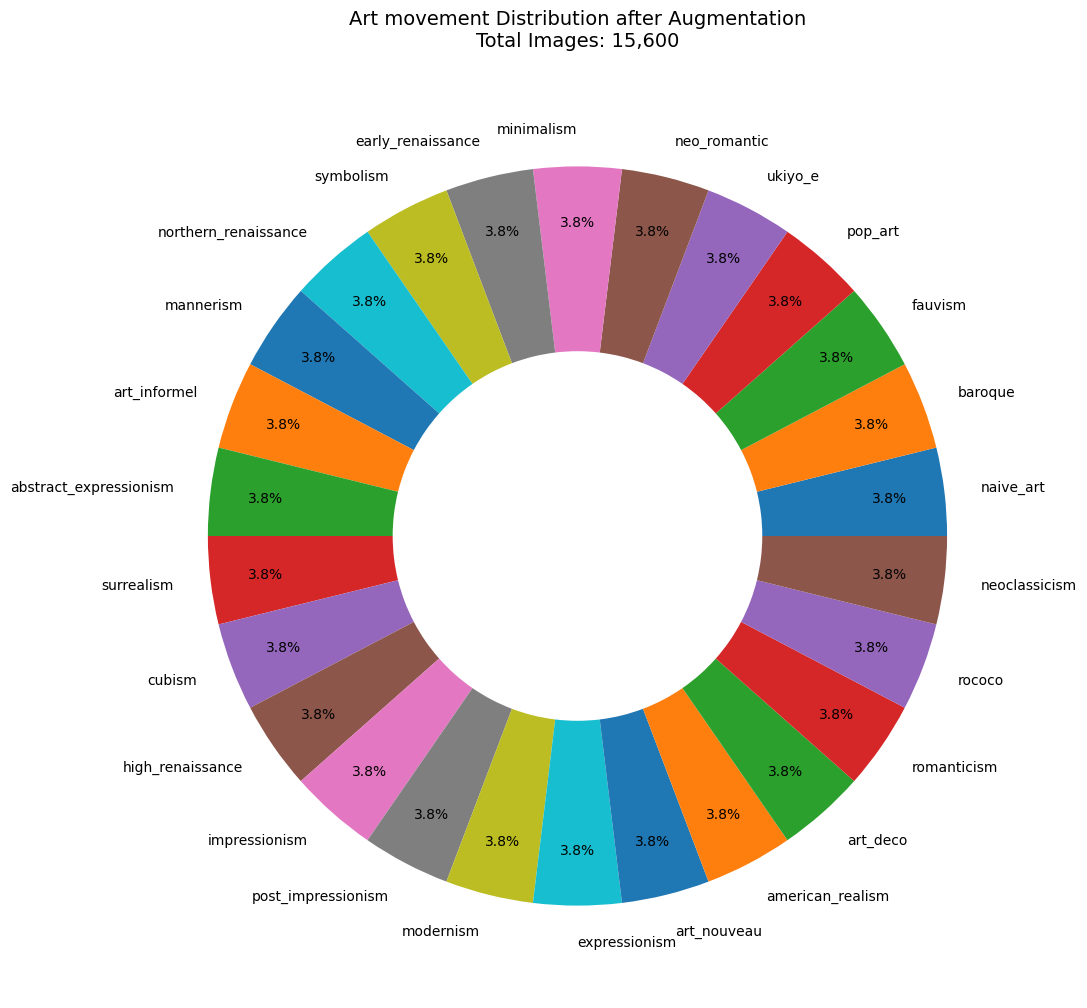

In [78]:
def plot_movement_pie(df):
    """
    Creates a pie chart of art movement distribution using matplotlib
    """
    plt.figure(figsize=(12, 12))
    
    # Get movement counts and total
    movement_counts = df['movement'].value_counts()
    total_images = len(df)
    
    # Create pie chart
    plt.pie(movement_counts.values, 
            labels=movement_counts.index,
            autopct='%1.1f%%',
            pctdistance=0.85,
            wedgeprops=dict(width=0.5))  # Creates donut effect
    
    plt.title(f"Art movement Distribution after Augmentation\nTotal Images: {total_images:,}", 
              pad=20, 
              size=14)
    
    return plt

#Usage:
plot_movement_pie(imageset_df)
plt.show()

In [79]:
imageset_df.columns

Index(['id', 'title', 'url', 'artistUrl', 'artistName', 'artistId',
       'completionYear', 'width', 'image', 'height', 'movement', 'file_path',
       'quality_score', 'image_array'],
      dtype='object')

In [82]:
# Drop columns we don't need. We'll keep the file_path
# and process the images into arrays during training.
training_imageset = imageset_df.drop(columns=['id', 'title', 'url', 'artistUrl', 'artistName', 'artistId',
       'completionYear', 'width', 'image', 'height', 'image_array','quality_score'], axis=1)

# Verify the new structure
training_imageset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movement   15600 non-null  object
 1   file_path  15600 non-null  object
dtypes: object(2)
memory usage: 243.9+ KB


In [83]:
training_imageset.to_csv('training_imageset_curated.csv', index=False)